In [23]:
import os
import cv2
from tqdm import tqdm

def preprocess_image(image_path, target_size):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        image = cv2.resize(image, target_size)
        image = image / 255.0
        return image
    except cv2.error as e:
        raise ValueError(f"Error processing image at path: {image_path}. Error: {e}")

source_dir = 'images/train'
target_dir = 'preprocessed'
target_size = (256, 256)
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

os.makedirs(target_dir, exist_ok=True)

for image_name in tqdm(os.listdir(source_dir)):
    if image_name.startswith('.') or not any(image_name.lower().endswith(ext) for ext in valid_extensions):
        continue
    image_path = os.path.join(source_dir, image_name)
    if not os.path.isfile(image_path):
        continue
    try:
        preprocessed_image = preprocess_image(image_path, target_size)
        # Convert the preprocessed image back to the [0, 255] range and uint8 type for saving
        preprocessed_image = (preprocessed_image * 255).astype('uint8')
        save_path = os.path.join(target_dir, image_name)
        cv2.imwrite(save_path, preprocessed_image)
    except (FileNotFoundError, ValueError) as e:
        print(e)


100%|██████████| 33126/33126 [3:28:42<00:00,  2.65it/s]   


In [21]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = 'image.zip'

# Specify the directory to extract to
extract_to_dir = 'images'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f'Files have been extracted to {extract_to_dir}')


Files have been extracted to images


In [44]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Load metadata
metadata_path = 'ISIC_2020_Training_GroundTruth (1).csv'  # Update with the actual path to your metadata CSV
metadata = pd.read_csv(metadata_path)

# Define the base dataset directory
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create class subdirectories
classes = ['benign', 'malignant']
for split_dir in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split data
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)



# Function to copy preprocessed images to corresponding directories

def copy_images(data, split_dir, preprocessed_dir):
    common_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    
    for _, row in data.iterrows():
        img_name = row['image_name']
        img_path = os.path.join(preprocessed_dir, img_name)
        
        # Attempt to find the file with different extensions
        found = False
        for ext in common_extensions:
            if os.path.isfile(img_path + ext):
                img_path += ext
                found = True
                break
        
        if not found:
            print(f"File not found for image_name: {img_name}. Checked with common extensions in {preprocessed_dir}")
            continue
        
        # Determine target directory based on label
        if row['target'] == 0:
            target_dir = os.path.join(split_dir, 'benign')
        else:
            target_dir = os.path.join(split_dir, 'malignant')
        
        shutil.copy(img_path, target_dir)
        print(f"Copied {img_path} to {target_dir}")
        
preprocessed_dir = 'preprocessed'  # Update with the actual path to your preprocessed images

# Assuming `train_data`, `val_data`, and `test_data` are already defined, as well as `train_dir`, `val_dir`, `test_dir`, and `preprocessed_dir`
copy_images(train_data, train_dir, preprocessed_dir)
copy_images(val_data, val_dir, preprocessed_dir)
copy_images(test_data, test_dir, preprocessed_dir)

        




print("Data preparation completed.")


Copied preprocessed/ISIC_7196094.jpg to dataset/train/benign
Copied preprocessed/ISIC_5495649.jpg to dataset/train/benign
Copied preprocessed/ISIC_1274550.jpg to dataset/train/benign
Copied preprocessed/ISIC_8209611.jpg to dataset/train/benign
Copied preprocessed/ISIC_5586153.jpg to dataset/train/benign
Copied preprocessed/ISIC_2582493.jpg to dataset/train/benign
Copied preprocessed/ISIC_1671282.jpg to dataset/train/benign
Copied preprocessed/ISIC_6641336.jpg to dataset/train/benign
Copied preprocessed/ISIC_6323199.jpg to dataset/train/benign
Copied preprocessed/ISIC_7574405.jpg to dataset/train/benign
Copied preprocessed/ISIC_9419841.jpg to dataset/train/benign
Copied preprocessed/ISIC_4913818.jpg to dataset/train/benign
Copied preprocessed/ISIC_6906476.jpg to dataset/train/benign
Copied preprocessed/ISIC_9416522.jpg to dataset/train/benign
Copied preprocessed/ISIC_4266467.jpg to dataset/train/benign
Copied preprocessed/ISIC_6992267.jpg to dataset/train/benign
Copied preprocessed/ISIC

In [2]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n-cls.pt')  # Load a pre-trained classification model

# Train the model
model.train(data='dataset', epochs=1, imgsz=640, batch=32)

# Evaluate the model using the test set
results = model.val(data='dataset')
print(results)


Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=dataset, epochs=1, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /workspace/dataset/train... 23850 images, 0 corrupt: 100%|██████████| 23850/23850 [00:00<?, ?it/s]
val: Scanning /workspace/dataset/val... 2650 images, 0 corrupt: 100%|██████████| 2650/2650 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train8
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:17<00:00,  1.86s/it]


                   all      0.984          1

1 epochs completed in 0.587 hours.
Optimizer stripped from runs/classify/train8/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train8/weights/best.pt, 3.0MB

Validating runs/classify/train8/weights/best.pt...
Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /workspace/dataset/train... found 23850 images in 2 classes ✅ 
val: /workspace/dataset/val... found 2650 images in 2 classes ✅ 
test: /workspace/dataset/test... found 6626 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:07<00:00,  1.61s/it]


                   all      0.984          1
Speed: 0.0ms preprocess, 15.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train8
Results saved to runs/classify/train8
Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /workspace/dataset/train... found 23850 images in 2 classes ✅ 
val: /workspace/dataset/val... found 2650 images in 2 classes ✅ 
test: /workspace/dataset/test... found 6626 images in 2 classes ✅ 


val: Scanning /workspace/dataset/val... 2650 images, 0 corrupt: 100%|██████████| 2650/2650 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]


                   all      0.984          1
Speed: 0.0ms preprocess, 11.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train82
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe14e28f910>
curves: []
curves_results: []
fitness: 0.9920754730701447
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9841509461402893, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9920754730701447}
save_dir: PosixPath('runs/classify/train82')
speed: {'preprocess': 0.0008883566226599352, 'inference': 11.76122728383766, 'loss': 9.833641772000294e-05, 'postprocess': 7.683376096329598e-05}
task: 'classify'
top1: 0.9841509461402893
top5: 1.0


In [63]:
pip install torch --upgrade


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 117.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 117.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 117.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 164.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 117.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 118.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 117.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 81.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 117.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
pip install ultralytics --upgrade


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 20.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.0a0
    Uninstalling torchvision-0.15.0a0:
      Successfully uninstalled torchvision-0.15.0a0
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.2.58
    Uninstalling ultralytics-8.2.58:
      Successfully uninstalled ultralytics-8.2.58
Note: you may need to restart the kernel to use updated packages.


In [1]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n-cls.pt')  # Load a pre-trained classification model

# Train the model
model.train(data='dataset', epochs=20, imgsz=640, batch=32)

# Evaluate the model using the test set
results = model.val(data='dataset')
print(results)


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=dataset, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /workspace/dataset/train... 23850 images, 0 corrupt: 100%|██████████| 23850/23850 [00:00<?, ?it/s]
val: Scanning /workspace/dataset/val... 2650 images, 0 corrupt: 100%|██████████| 2650/2650 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train10
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:14<00:00,  1.76s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:12<00:00,  1.73s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:07<00:00,  1.61s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:05<00:00,  1.56s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:03<00:00,  1.50s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:05<00:00,  1.57s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:09<00:00,  1.66s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20         0G    0.07495         10        640: 100%|██████████| 746/746 [30:28<00:00,  2.45s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:04<00:00,  1.53s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G    0.07418         10        640: 100%|██████████| 746/746 [30:58<00:00,  2.49s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:03<00:00,  1.51s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20         0G    0.07257         10        640: 100%|██████████| 746/746 [31:54<00:00,  2.57s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20         0G    0.07133         10        640: 100%|██████████| 746/746 [32:28<00:00,  2.61s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:02<00:00,  1.48s/it]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20         0G    0.07137         10        640: 100%|██████████| 746/746 [31:07<00:00,  2.50s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:11<00:00,  1.71s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20         0G    0.07078         10        640: 100%|██████████| 746/746 [31:01<00:00,  2.50s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:10<00:00,  1.67s/it]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20         0G     0.0684         10        640: 100%|██████████| 746/746 [30:51<00:00,  2.48s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:03<00:00,  1.52s/it]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20         0G    0.06728         10        640: 100%|██████████| 746/746 [30:55<00:00,  2.49s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:06<00:00,  1.59s/it]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20         0G    0.06661         10        640: 100%|██████████| 746/746 [30:47<00:00,  2.48s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:11<00:00,  1.69s/it]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20         0G    0.06565         10        640: 100%|██████████| 746/746 [30:29<00:00,  2.45s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:04<00:00,  1.54s/it]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20         0G    0.06512         10        640: 100%|██████████| 746/746 [30:04<00:00,  2.42s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [01:02<00:00,  1.48s/it]

                   all      0.983          1



20 epochs completed in 10.636 hours.
Optimizer stripped from runs/classify/train10/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train10/weights/best.pt, 3.0MB

Validating runs/classify/train10/weights/best.pt...
Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /workspace/dataset/train... found 23850 images in 2 classes ✅ 
val: /workspace/dataset/val... found 2650 images in 2 classes ✅ 
test: /workspace/dataset/test... found 6626 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 42/42 [00:53<00:00,  1.26s/it]


                   all      0.985          1
Speed: 0.0ms preprocess, 12.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train10
Results saved to runs/classify/train10
Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /workspace/dataset/train... found 23850 images in 2 classes ✅ 
val: /workspace/dataset/val... found 2650 images in 2 classes ✅ 
test: /workspace/dataset/test... found 6626 images in 2 classes ✅ 


val: Scanning /workspace/dataset/val... 2650 images, 0 corrupt: 100%|██████████| 2650/2650 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s]


                   all      0.985          1
Speed: 0.0ms preprocess, 10.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train102
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb6ddeadaf0>
curves: []
curves_results: []
fitness: 0.9922641515731812
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9845283031463623, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9922641515731812}
save_dir: PosixPath('runs/classify/train102')
speed: {'preprocess': 0.0006253764314471551, 'inference': 10.074995598703062, 'loss': 4.480469901606722e-05, 'postprocess': 5.9649629412956966e-05}
task: 'classify'
top1: 0.9845283031463623
top5: 1.0


In [118]:
# Evaluate the model on the validation set
import matplotlib.pyplot as plt
metrics = model.val(data=os.path.join(output_dir, 'dataset.yaml'))

# Print the evaluation metrics
print(metrics)
# Show plot
plt.show()


Ultralytics YOLOv8.2.64 🚀 Python-3.8.10 torch-2.4.0+cu121 CPU (AMD EPYC 7742 64-Core Processor)


val: Scanning /workspace/dataset/val... 2650 images, 0 corrupt: 100%|██████████| 2650/2650 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 166/166 [00:44<00:00,  3.70it/s]


                   all      0.984          1
Speed: 0.0ms preprocess, 9.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val4
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb6cc2b7be0>
curves: []
curves_results: []
fitness: 0.9920754730701447
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9841509461402893, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9920754730701447}
save_dir: PosixPath('runs/classify/val4')
speed: {'preprocess': 0.0012529121254974942, 'inference': 9.531547438423589, 'loss': 0.00012955575619103774, 'postprocess': 0.0001422414239847435}
task: 'classify'
top1: 0.9841509461402893
top5: 1.0


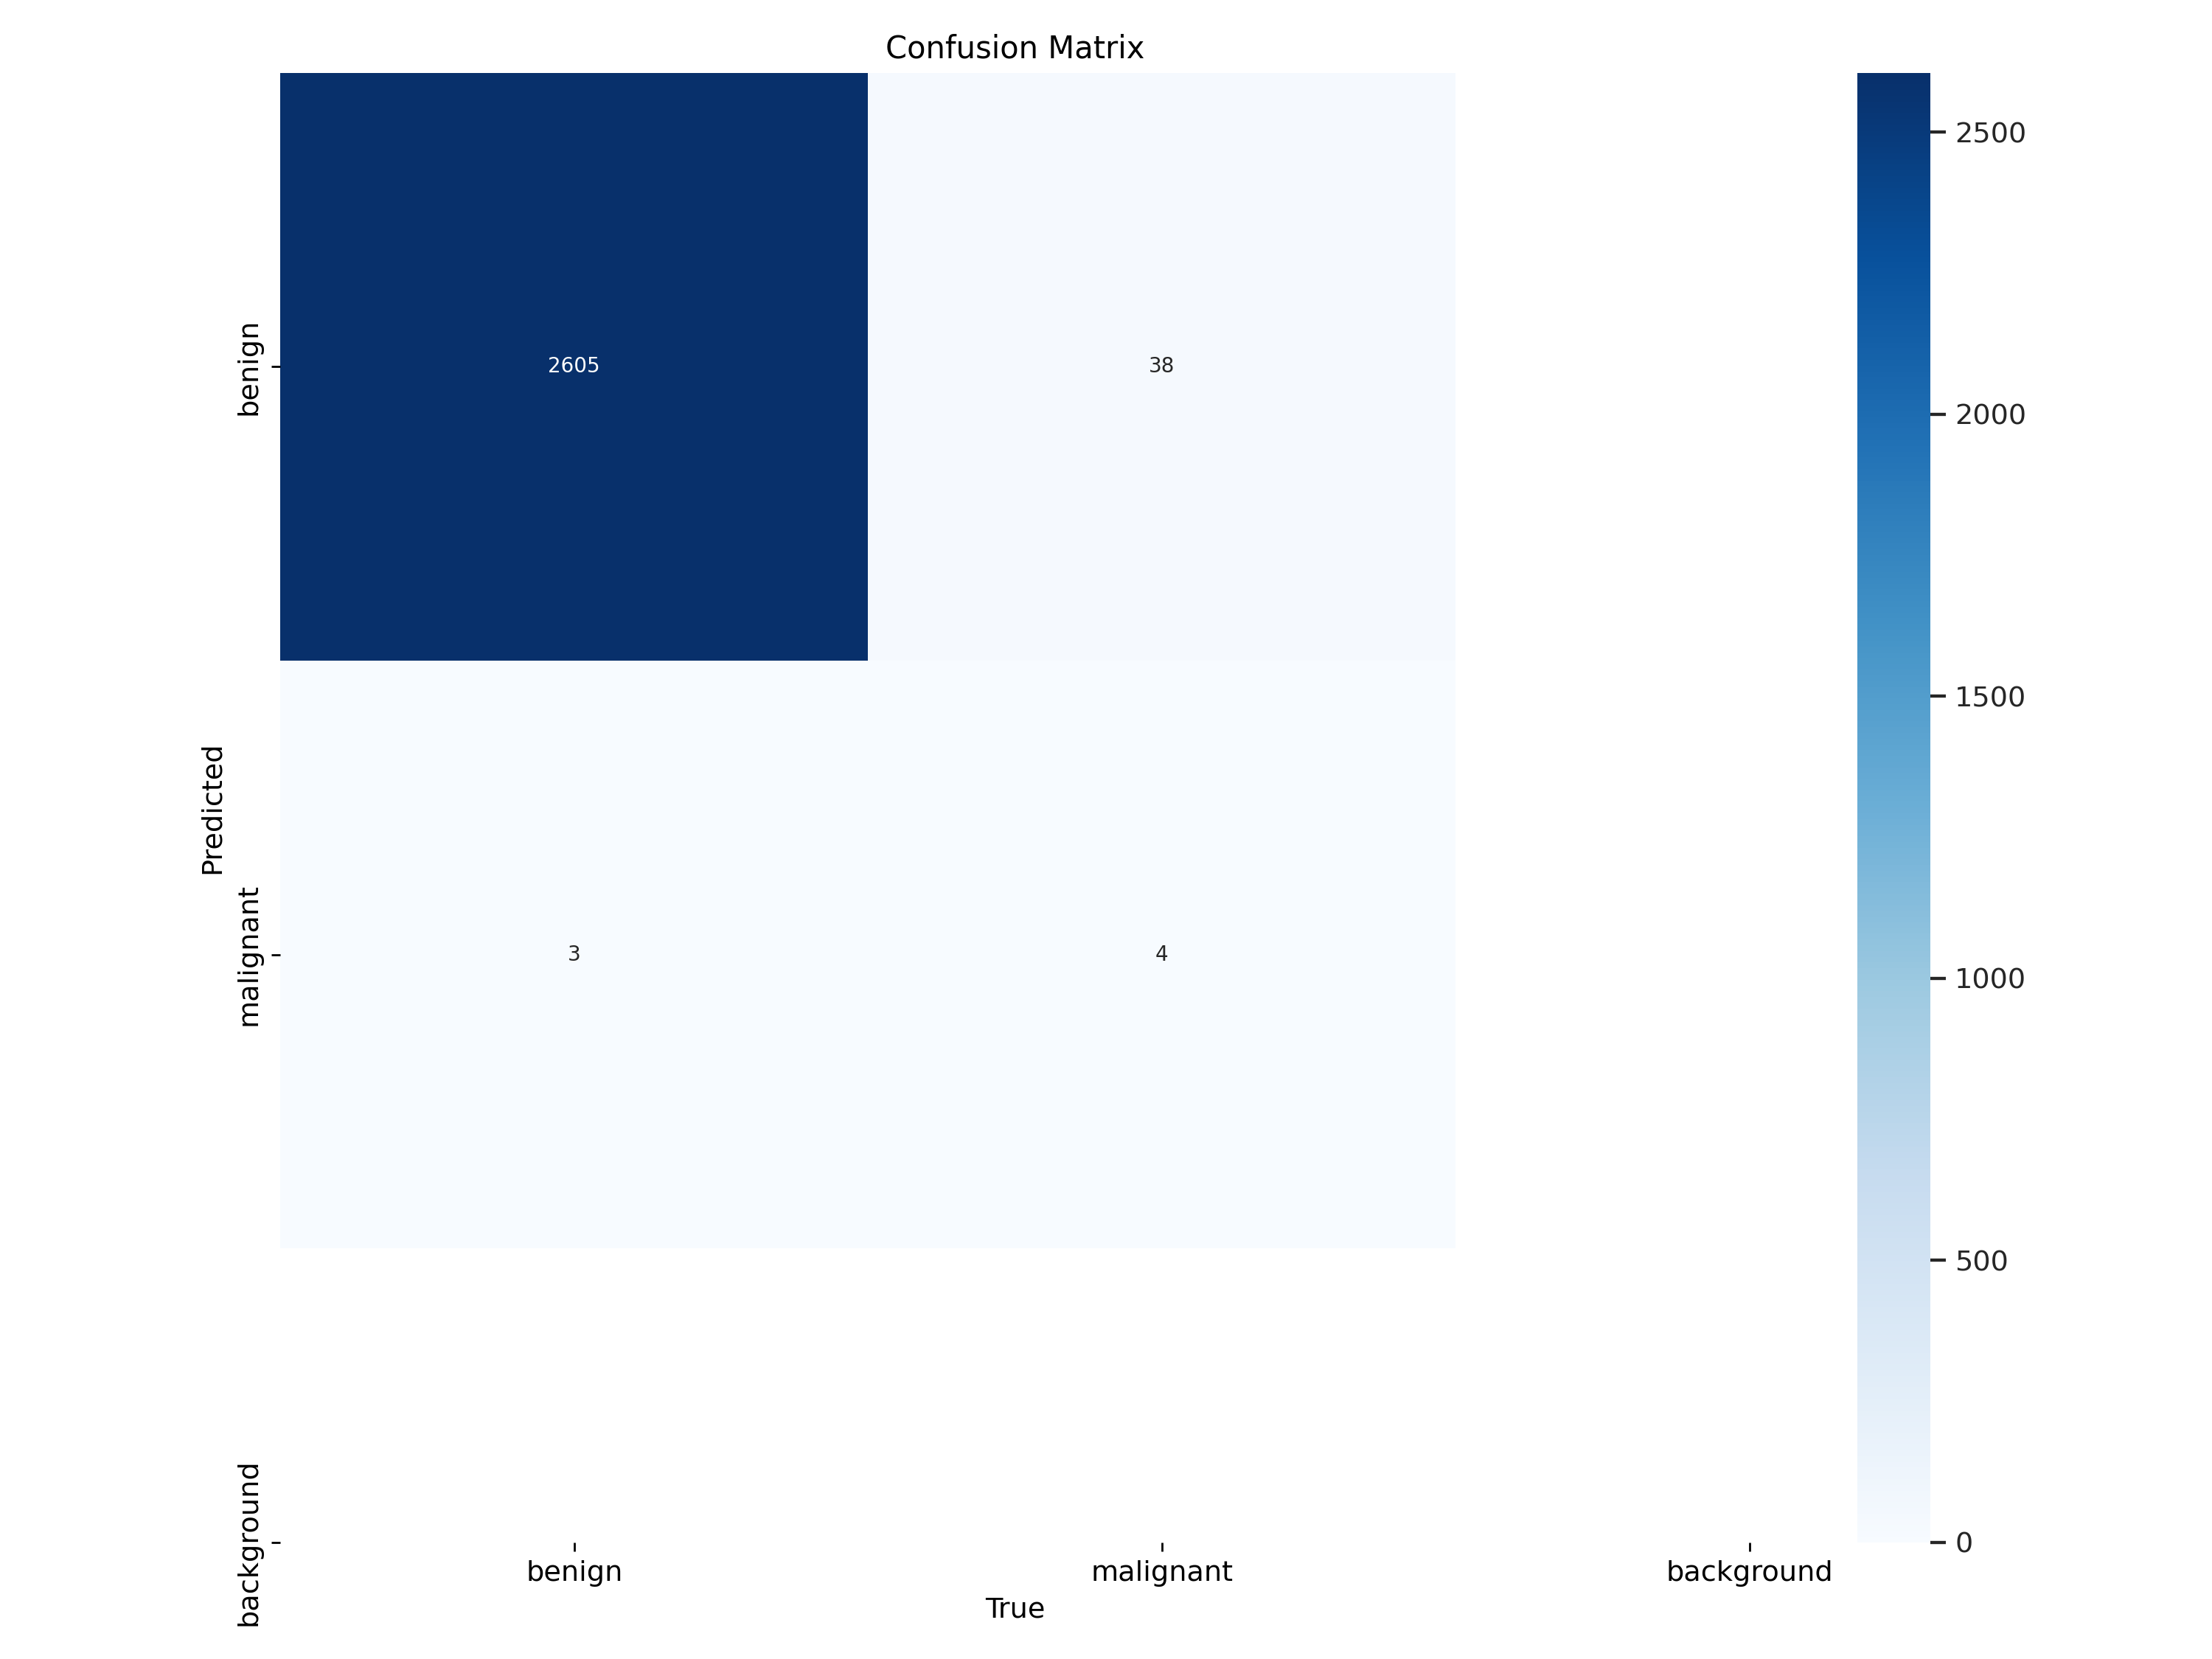

In [158]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import IPython.display as display
 
# Open and display the image using PIL
img = Image.open('runs/classify/train10/confusion_matrix.png')
display.display(img)

# Show the plot
plt.show()


In [226]:
from ultralytics import YOLO
import os

# Define the output directory
output_dir = 'output_directory'  # Replace with your desired output directory

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Load the model with the best weights
model = YOLO('output_directory/best_train10_model.pt')

# Save the model weights
model.save(os.path.join(output_dir, 'best_train10_model.pt'))

print("Model saved successfully")


Model saved successfully


In [227]:
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on validation set
predictions = model.predict(X_val)

# Load best weights
model = YOLO('output_directory/best_train10_model.pt')

# Convert predictions to labels if necessary (depends on your model output format)
# Here, let's assume predictions are in the form of strings
predicted_labels = [prediction for prediction in predictions]

# Assuming `true_labels` and `predicted_labels` are lists of true and predicted labels
true_labels = [0, 1]  # Your true labels here
predicted_labels = ['benign', 'malignant']  # Your predicted labels here

# Map string labels to numeric labels
label_mapping = {'benign': 0, 'malignant': 1}
predicted_labels = [label_mapping[label] for label in predicted_labels]

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


image 1/1 /workspace/runs/classify/train7/val_batch0_pred.jpg: 640x640 benign 0.99, malignant 0.01, 20.5ms
Speed: 32.9ms preprocess, 20.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [232]:
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from ultralytics import YOLO

# Load best weights
model = YOLO('output_directory/best_train10_model.pt')

# Prepare your data
def prepare_image(images):
    img = load_img(image_path, target_size=(128, 128))  # Resize as needed
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('uint8')  # Convert to uint8
    return img_array

# Function to load all images from a directory and assign the corresponding label
def load_images_from_directory(directory, label):
    image_paths = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(directory, filename))
            labels.append(label)
    return image_paths, labels

# Load your test dataset and true labels
malignant_dir = 'dataset/test/malignant'
benign_dir = 'dataset/test/benign'

malignant_image_paths, malignant_labels = load_images_from_directory(malignant_dir, 1)
benign_image_paths, benign_labels = load_images_from_directory(benign_dir, 0)

# Combine the image paths and labels
test_image_paths = malignant_image_paths + benign_image_paths
true_labels = malignant_labels + benign_labels

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test images and get predictions
for image_path, true_label in zip(test_image_paths, true_labels):
    img_array = prepare_image(image_path)
    results = model.predict(img_array)  # Get the prediction results

    # Extract the class probabilities (assume results are in a list of 'Probs' objects)
    prob = results[0].probs  # Extract the probability tensor
    if prob.shape[0] > 1:  # Check if batch size is more than 1
        prob = prob[0]  # Take the first image in the batch if there are multiple
    
    # Convert probabilities to predicted class (assumes binary classification)
    predicted_class = np.argmax(prob, axis=0)  # Get the index of the max probability

    y_pred.append(predicted_class)
    y_true.append(true_label)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')



0: 640x640 benign 0.99, malignant 0.01, 96.3ms
Speed: 852.8ms preprocess, 96.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 65.2ms
Speed: 723.0ms preprocess, 65.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 72.6ms
Speed: 673.5ms preprocess, 72.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 99.6ms
Speed: 738.2ms preprocess, 99.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 56.9ms
Speed: 728.9ms preprocess, 56.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 106.1ms
Speed: 738.3ms preprocess, 106.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 benign 0.99, malignant 0.01, 72.1ms
Speed: 787.6ms preprocess, 72.1ms inference, 0.1ms postprocess per i

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Precision: 0.9644
Recall: 0.9820
F1 Score: 0.9731